In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

class PreProcessing: 
  def download_data_from_UCI():
    ''' pull data from UCI repository ''' 

    !rm -rf 'sentiment labelled sentences'
    !rm -rf 'sentiment labelled sentences.zip'
    !rm -rf '__MACOSX'
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip
    !unzip 'sentiment labelled sentences.zip'

    return 0 


  def convert_to_df(): 
    ''' Pull downloaded data from repository and store as pandas dataframe. '''
    #  import amzn reviews and covert to dataframe 
    amzn = pd.read_csv('sentiment labelled sentences/amazon_cells_labelled.txt', 
                      names=['sentence', 'label'], sep='\t')
    #  import imdb reviews and covert to dataframe 
    imdb = pd.read_csv('sentiment labelled sentences/imdb_labelled.txt', 
                      names=['sentence', 'label'], sep='\t')
    return amzn, imdb


  def __segregate_sentences_sentiment(df):
    ''' This is an internal method called within the function used to split 
        training and test data. Pass input dataframe containing sentences and 
        sentiment labels in order to separate into individual lists. '''
    sentences = df['sentence'].values  # extract sentences from df and store 
    sentiment = df['label'].values  # extrant sentiment labels from df and store 

    return sentences, sentiment 


  def split_train_test_data(df): 
    ''' Pass raw dataframe into this method. It calls internal method from 
        PreProcessing class to split into X and Y dataframes. Then it applies 
        SKL train_test_split function to create train, test data sets. ''' 
    # call internal method to split input dataframe into X, y sets 
    sentences, sentiment = PreProcessing.__segregate_sentences_sentiment(df) 
    # call train_test_split function to separate sentences, sentiment into 2 sets 
    X_train, X_test, y_train, y_test = train_test_split(sentences, sentiment, 
                                                        test_size=0.25, 
                                                        random_state=42)
    return X_train, X_test, y_train, y_test 

In [69]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

class DataTransformations: 
  def vectorize_data(train_X, test_X): 
    ''' This method accepts train, test X data (i.e. sentences) and applies 
        'bag of words' paradigm to count instances of each word within the 
        vocabulary. Note: Do NOT pass train, test Y data (i.e. labels). '''

    # instantiate CountVectorizer instance 
    vectorizer = CountVectorizer(min_df=0, lowercase=False, 
                                 stop_words='english')
    # fit object to input data 
    vectorizer.fit(train_X)
    # transform input data 
    vectorized_train = vectorizer.transform(train_X).toarray()
    vectorized_test = vectorizer.transform(test_X).toarray()

    return vectorized_train, vectorized_test


  def tokenize(sentences_train, sentences_test):
    tokenizer = Tokenizer(num_words=5000)  # instantiate tokenizer 
    tokenizer.fit_on_texts(sentences_train)  # fit tokenizer to train set 

    # apply fitted tokenizer to train set 
    tokenized_train = tokenizer.texts_to_sequences(sentences_train) 
    # "                       " test set 
    tokenized_test = tokenizer.texts_to_sequences(sentences_test)
    return tokenized_train, tokenized_test, tokenizer 


  def pad_tokens(tokenized_train, tokenized_test, max_len): 
    pad_tokenized_train = pad_sequences(tokenized_train, padding='post', 
                                        maxlen=max_len)
    pad_tokenized_test = pad_sequences(tokenized_test, padding='post', 
                                       maxlen=max_len)
    return pad_tokenized_train, pad_tokenized_test


  def one_hot_encoding(pad_token_train, pad_token_test, max_len): 
    
    all_labels = pad_token_train.reshape(-1,)  # store number of features 
    
    enc = OneHotEncoder(sparse=False, handle_unknown = 'ignore')  
    enc.fit(all_labels.reshape(len(all_labels),1))  # fit encoder to num fts
    
    enc_train = []  # initialize empty list to hold ecoded train data 
    for i in range(len(pad_token_train)):  # iter across train data 
      enc_train.append(enc.transform(pad_token_train[i].reshape(max_len, 1)))
    enc_test = []  # repeat for test data 
    for i in range(len(pad_token_test)): 
      enc_test.append(enc.transform(pad_token_test[i].reshape(max_len, 1)))

    enc_train = np.asarray(enc_train)  # convert list to numpy array 
    enc_test = np.asarray(enc_test)  # repeat for test data 

    flat_train = enc_train.reshape(enc_train.shape[0], 100*enc_train.shape[2])
    flat_test = enc_test.reshape(enc_test.shape[0], 100*enc_test.shape[2])

    return flat_train, flat_test


  def get_vocab_size(token): 
    vocab_size = len(token.word_index) + 1  # add 1 to vocab size for 0 word 

    return vocab_size 

In [70]:
from sklearn.linear_model import LogisticRegression

class LogisticRegressor: 
  def log_reg(X_train, X_test, y_train, y_test): 
    ''' Define method to perform logistic regression on sentiment data. This 
        method accepts the train and test X, y data. It uses the former to fit 
        the model and the latter to score its performance. '''
    logistic_classifier = LogisticRegression()  # instantiate object 
    logistic_classifier.fit(X_train, y_train)  # fit regressor to train data
    score = logistic_classifier.score(X_test, y_test)  # score model w test data

    print("Log regression accuracy:", score)
    return score 

In [89]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout,Activation
from keras.layers import BatchNormalization,Dense
from keras.regularizers import l2
from keras import initializers,Sequential
from keras.layers import Embedding
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

class KerasNetwork: 
  def build_model(n_layers, n_neurons, initializer, internal_func, output_func):
    ''' This method creates a neural network using the Keras API. It defines 
        the network using the input number of layers and neurons, (weights)
        initialization method, internal (hidden layer) activation function, and 
        output activation function. '''

    if initializer == 'uniform':
      w_in = np.sqrt(0.001)
      initializer = initializers.RandomUniform(minval=-w_in, maxval=w_in)
    else:
      initializer = initializers.glorot_normal()
    
    model = Sequential() # create Sequential model
    for i in range(n_layers-1):  # iterate across each layer 
      model.add(Dense(n_neurons, kernel_initializer=initializer))  # neurons
      model.add(BatchNormalization())  # apply batch normalization
      model.add(Activation(internal_func))  # define activation function 
      model.add(Dropout(0.2))
    model.add(Dense(1, activation = output_func, 
                    kernel_initializer=initializer)) 
    return model


  def embedded_model(n_layers, n_neurons, initializer, vocab, embed_dim, max_len, internal_func, output_func): 
    ''' This method also creates a neural network using the Keras API. However 
        unlike the 'build_model' method this utilizes the embedding layer of 
        Keras to map the tokenized and padded input features to a dense vector. 
        '''
    if initializer == 'uniform': 
      w_in = np.sqrt(0.001)
      initializer = initializers.RandomUniform(minval=w_in, maxval=w_in)
    else: 
      initializer = initializers.glorot_normal()
    
    model = Sequential()  
    model.add(Embedding(input_dim=vocab, output_dim=embed_dim, 
                        input_length=max_len, embeddings_initializer=None))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(n_neurons, activation=internal_func))
    model.add(Dense(1, activation=output_func, kernel_initializer=initializer))

    return model 
  
  def plot_metrics(train_results): 
    ''' Pass training outputs stored in variable to this method to plot 
        training loss and accuracy over epochs. '''
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)  # instantiate LHS of 2 figure subplot 

    plt.plot(train_results.history['loss'], label='Training')  # train loss
    plt.plot(train_results.history['val_loss'], label='Validation')  # val loss 
    plt.title('Loss: Training and Validation', fontsize=15)  # set plot title
    plt.ylabel('Loss', fontsize=15)  # set Y axis label 
    plt.xlabel('Epoch', fontsize=15)  # set X axis label 
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='upper right', fontsize = 12)

    plt.subplot(1,2,2)  # instantiate RHS of 2 figure subplot 
    plt.plot(train_results.history['accuracy'], label='Training')  
    plt.plot(train_results.history['val_accuracy'], label='Validation')   
    plt.title('Accuracy: Training and Validation', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right', fontsize=12)
    plt.tight_layout()
    plt.show()
    return 0 

## Preprocessing raw data

Download data from UCI repository and import as pandas dataframe for processing. I intend to run sentiment analysis using neural networks on Amazon and IMDB reviews. First I split the reviews into 'sentences' and 'sentiment' (X, Y) and then into train, test data sets. 

In [ ]:
# run function to pull data 
PreProcessing.download_data_from_UCI() 
# convert data to pandas dataframes 
amazon_df, imdb_df = PreProcessing.convert_to_df()  

# split dataframe into train and test data 
sent_trainA, sent_testA, label_trainA, label_testA = PreProcessing.split_train_test_data(amazon_df)
sent_trainI, sent_testI, label_trainI, label_testI = PreProcessing.split_train_test_data(imdb_df)

--2021-11-30 21:59:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84188 (82K) [application/x-httpd-php]
Saving to: ‘sentiment labelled sentences.zip’

sentiment labelled  100%[===================>]  82.21K   279KB/s    in 0.3s    

2021-11-30 21:59:04 (279 KB/s) - ‘sentiment labelled sentences.zip’ saved [84188/84188]

Archive:  sentiment labelled sentences.zip
   creating: sentiment labelled sentences/
  inflating: sentiment labelled sentences/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/sentiment labelled sentences/
  inflating: __MACOSX/sentiment labelled sentences/._.DS_Store  
  inflating: sentiment labelled sentences/amazon_cells_labelled.txt  
  inflating: sentiment labelled sentences/imdb_labelle

# Initial attempt at building a neural network 

I converted the train and test sentences into feature vectors using the 'bag of words' paradigm for my first attempt at training a neural network. I defined the network parameters (number of layers, neurons, and initialization) in the callback to the Keras API. I used the binary cross entropy loss function and recorded the loss and accuracy during training. The figure below plots both of these metrics and also presents the model accuracy on the test data set. 


Epoch 1/50
135/135 [==============================] - 1s 5ms/step - loss: 0.6902 - accuracy: 0.5467 - val_loss: 0.6807 - val_accuracy: 0.6800
Epoch 2/50
135/135 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.8237 - val_loss: 0.6708 - val_accuracy: 0.7333
Epoch 3/50
135/135 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.9244 - val_loss: 0.6612 - val_accuracy: 0.7867
Epoch 4/50
135/135 [==============================] - 0s 4ms/step - loss: 0.6207 - accuracy: 0.9422 - val_loss: 0.6520 - val_accuracy: 0.7733
Epoch 5/50
135/135 [==============================] - 0s 3ms/step - loss: 0.5990 - accuracy: 0.9511 - val_loss: 0.6431 - val_accuracy: 0.8000
Epoch 6/50
135/135 [==============================] - 0s 3ms/step - loss: 0.5784 - accuracy: 0.9526 - val_loss: 0.6346 - val_accuracy: 0.8000
Epoch 7/50
135/135 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.9541 - val_loss: 0.6267 - val_accuracy: 0.8000
Epoch 

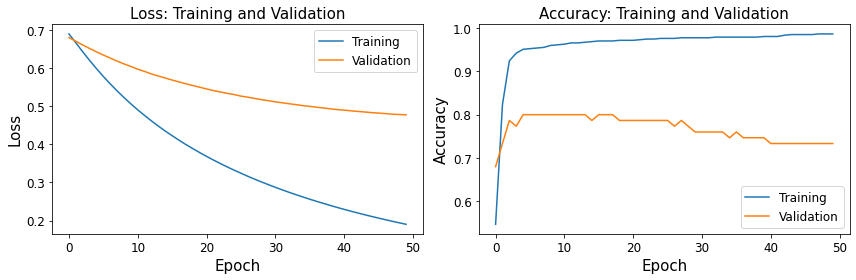

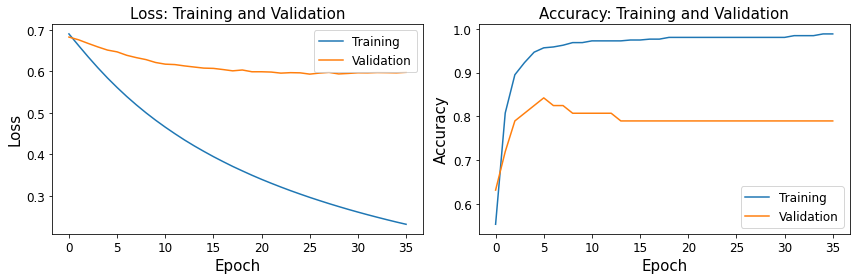

6/6 [==============================] - 0s 4ms/step - loss: 0.5674 - accuracy: 0.7433
Accuracy of neural network model on AMZN data: 0.800000011920929
Accuracy of neural network model on IMDB data: 0.7433155179023743


In [57]:
# convert train and test sentences to numerical counts 
X_trainA, X_testA = DataTransformations.vectorize_data(sent_trainA, sent_testA)
X_trainI, X_testI = DataTransformations.vectorize_data(sent_trainI, sent_testI)

# define callback params to keras API 
keras_callbacks = [EarlyStopping(monitor='val_loss', patience=10, mode='min', 
                                 min_delta=0.0001), 
                   ModelCheckpoint('./checkmodel.h5', monitor='val_loss', 
                                   save_best_only=True, mode='min')]
# define network layers, number of neurons, and initialization 
modelA = KerasNetwork.build_model(1, 20, 'uniform', 'relu', 'sigmoid')
modelI = KerasNetwork.build_model(1, 20, 'uniform', 'relu', 'sigmoid')
# compile model with defined loss function and optimization 
modelA.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=['accuracy'])
modelI.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=['accuracy'])
# fit model to train data sets 
historyAmzn = modelA.fit(X_trainA, label_trainA, validation_split=0.1, 
                        batch_size=5, epochs=50, callbacks=keras_callbacks)
historyImdb = modelI.fit(X_trainI, label_trainI, validation_split=0.1, 
                        batch_size=5, epochs=50, callbacks=keras_callbacks)
# plot model loss and accuracy 
KerasNetwork.plot_metrics(historyAmzn)
KerasNetwork.plot_metrics(historyImdb)
# evaluate model on test data 
accuracyA = modelA.evaluate(X_testA, label_testA)
accuracyI = modelI.evaluate(X_testI, label_testI)
# print model accuracy 
print("Accuracy of neural network model on AMZN data:", accuracyA[1])
print("Accuracy of neural network model on IMDB data:", accuracyI[1])

# Second attempt at neural network 

My first attempt at using a neural network resulted in ~80.0% accuracy at gauging positive or negative sentiment of the Amazon reviews and 74.3% accuracy for the IMDB reviews. I previously vectorized the input sentences (generating vocabulary, counting instances of each word per sentence and storing in feature vector), so this time I applied tokenization instead. This maps each word within the vocabulary to an integer and therefore convert the text data into numeric. 

Neural networks improve their performance when input data has similar feature type and length. Sentence length can vary significantly, which may decrease network performance. Therefore, I will 'pad' the ends of each 'sentence' (now a list of integers post-tokenization) with 0's to ensure uniform length. I also applied 'one-hot-encoding' to the padded tokens in order to prevent the network from potentially training on the value of a given number within the padded tokens (i.e. 98 does not have greater significance towards training than 9 because the two encode a randomly-selected word that may or may not have importance). 

Epoch 1/50
135/135 [==============================] - 1s 6ms/step - loss: 0.6913 - accuracy: 0.5319 - val_loss: 0.7204 - val_accuracy: 0.4400
Epoch 2/50
135/135 [==============================] - 1s 5ms/step - loss: 0.6629 - accuracy: 0.6193 - val_loss: 0.6785 - val_accuracy: 0.6133
Epoch 3/50
135/135 [==============================] - 1s 4ms/step - loss: 0.6139 - accuracy: 0.7378 - val_loss: 0.7000 - val_accuracy: 0.5067
Epoch 4/50
135/135 [==============================] - 1s 4ms/step - loss: 0.5824 - accuracy: 0.8000 - val_loss: 0.6931 - val_accuracy: 0.5200
Epoch 5/50
135/135 [==============================] - 1s 5ms/step - loss: 0.5517 - accuracy: 0.8430 - val_loss: 0.6618 - val_accuracy: 0.6400
Epoch 6/50
135/135 [==============================] - 1s 4ms/step - loss: 0.5191 - accuracy: 0.9096 - val_loss: 0.6520 - val_accuracy: 0.6667
Epoch 7/50
135/135 [==============================] - 1s 4ms/step - loss: 0.4923 - accuracy: 0.9244 - val_loss: 0.6485 - val_accuracy: 0.6533
Epoch 

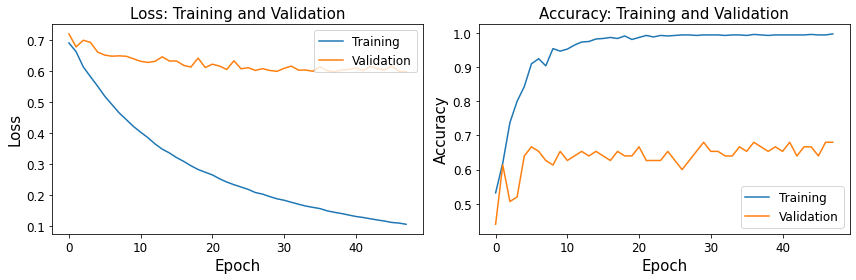

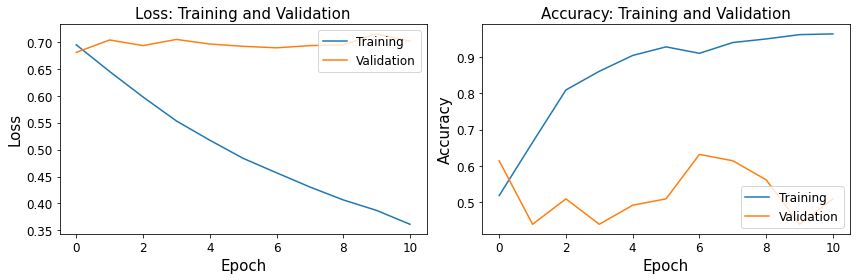

6/6 [==============================] - 0s 16ms/step - loss: 0.6870 - accuracy: 0.5615
Accuracy of 2nd Network Model on AMZN data: 0.6800000071525574
Accuracy of 2nd Network Model on IMDB data: 0.5614973306655884


In [43]:
# tokenize train, test sentences 
X_trainA2, X_testA2, tokenA = DataTransformations.tokenize(sent_trainA, 
                                                           sent_testA)
X_trainI2, X_testI2, tokenI = DataTransformations.tokenize(sent_trainI, 
                                                           sent_testI)
# pad tokenized train, test sets with 0s as necessary 
X_trainA2, X_testA2 = DataTransformations.pad_tokens(X_trainA2, X_testA2, 100)
X_trainI2, X_testI2 = DataTransformations.pad_tokens(X_trainI2, X_testI2, 100)
# one-hot encode tokenized and padded vectors 
X_trainA2, X_testA2 = DataTransformations.one_hot_encoding(X_trainA2, X_testA2, 
                                                           100)
X_trainI2, X_testI2 = DataTransformations.one_hot_encoding(X_trainI2, X_testI2, 
                                                           100)

## second network build (same params as Attempt #1)
modelA2 = KerasNetwork.build_model(1, 20, 'uniform', 'relu', 'sigmoid')
modelI2 = KerasNetwork.build_model(1, 20, 'uniform', 'relu', 'sigmoid')
modelA2.compile(loss = "binary_crossentropy", optimizer = "adam", 
              metrics = ['accuracy'])
modelI2.compile(loss = "binary_crossentropy", optimizer = "adam", 
              metrics = ['accuracy'])
# fit model to train data
historyAmzn = modelA2.fit(X_trainA2, label_trainA, validation_split=0.1, 
                     batch_size = 5, epochs = 50, callbacks=keras_callbacks)
historyImdb = modelI2.fit(X_trainI2, label_trainI, validation_split=0.1, 
                     batch_size = 5, epochs = 50, callbacks=keras_callbacks)
# plot model loss and accuracy 
KerasNetwork.plot_metrics(historyAmzn)
KerasNetwork.plot_metrics(historyImdb)
# evaluate model loss and accuracy 
accuracyA = modelA2.evaluate(X_testA2, label_testA)
accuracyI = modelI2.evaluate(X_testI2, label_testI)
# print model accuracy 
print('Accuracy of 2nd Network Model on AMZN data:', accuracyA[1])
print('Accuracy of 2nd Network Model on IMDB data:', accuracyI[1])

# Third attempt at neural network 

After changing the input sentences to a tokenized, padded, and one-hot encoded feature sets while maintaining the same network architecture (1 layer, 10 neurons), I saw the accuracy decrease from 80.0% to 67.1% and from 74.3% to 54.0% for the Amazon and IMDB data respectively. This occurred unexpectedly as I assumed that the more processed input would promote superior results. 

Therefore, I modified the network (hyper)parameters in an attempt to improve performance. I maintained the same tokenized, padded, and one-hot encoded feature set but increased the number of layers and number of neurons per layer to 3 and 10 respectively.  

Epoch 1/50
135/135 [==============================] - 3s 12ms/step - loss: 0.6929 - accuracy: 0.5096 - val_loss: 0.6929 - val_accuracy: 0.5600
Epoch 2/50
135/135 [==============================] - 1s 10ms/step - loss: 0.6608 - accuracy: 0.6800 - val_loss: 0.6876 - val_accuracy: 0.5333
Epoch 3/50
135/135 [==============================] - 1s 10ms/step - loss: 0.5611 - accuracy: 0.7630 - val_loss: 0.7206 - val_accuracy: 0.5600
Epoch 4/50
135/135 [==============================] - 1s 10ms/step - loss: 0.4959 - accuracy: 0.8000 - val_loss: 0.6180 - val_accuracy: 0.6800
Epoch 5/50
135/135 [==============================] - 1s 10ms/step - loss: 0.4114 - accuracy: 0.8459 - val_loss: 0.6223 - val_accuracy: 0.6533
Epoch 6/50
135/135 [==============================] - 1s 10ms/step - loss: 0.3887 - accuracy: 0.8489 - val_loss: 0.7990 - val_accuracy: 0.6000
Epoch 7/50
135/135 [==============================] - 1s 10ms/step - loss: 0.3418 - accuracy: 0.8800 - val_loss: 0.8243 - val_accuracy: 0.6267

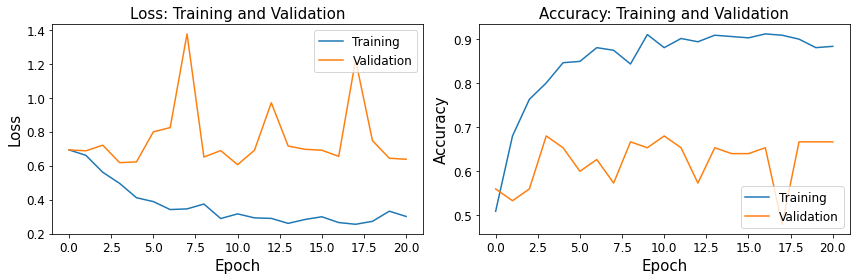

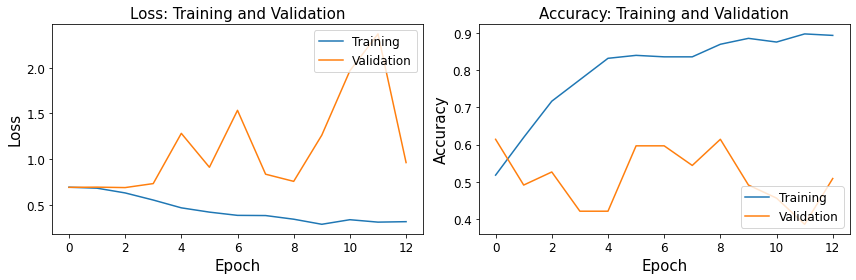

6/6 [==============================] - 0s 14ms/step - loss: 0.8639 - accuracy: 0.5294
Accuracy of 2nd Network Model on AMZN data: 0.6399999856948853
Accuracy of 2nd Network Model on IMDB data: 0.529411792755127


In [78]:
# tokenize train, test sentences 
X_trainA2, X_testA2, tokenA = DataTransformations.tokenize(sent_trainA, 
                                                           sent_testA)
X_trainI2, X_testI2, tokenI = DataTransformations.tokenize(sent_trainI, 
                                                           sent_testI)
# pad tokenized train, test sets with 0s as necessary 
X_trainA2, X_testA2 = DataTransformations.pad_tokens(X_trainA2, X_testA2, 100)
X_trainI2, X_testI2 = DataTransformations.pad_tokens(X_trainI2, X_testI2, 100)
# one-hot encode tokenized and padded vectors 
X_trainA2, X_testA2 = DataTransformations.one_hot_encoding(X_trainA2, X_testA2, 
                                                           100)
X_trainI2, X_testI2 = DataTransformations.one_hot_encoding(X_trainI2, X_testI2, 
                                                           100)

## third network build (modifiy params compared to Attempt #2)
modelA3 = KerasNetwork.build_model(3, 10, 'uniform', 'relu', 'sigmoid')
modelI3 = KerasNetwork.build_model(3, 10, 'uniform', 'relu', 'sigmoid')
modelA3.compile(loss = "binary_crossentropy", optimizer = "adam", 
              metrics = ['accuracy'])
modelI3.compile(loss = "binary_crossentropy", optimizer = "adam", 
              metrics = ['accuracy'])
# fit model to train data
historyAmzn = modelA3.fit(X_trainA2, label_trainA, validation_split=0.1, 
                     batch_size = 5, epochs = 50, callbacks=keras_callbacks)
historyImdb = modelI3.fit(X_trainI2, label_trainI, validation_split=0.1, 
                     batch_size = 5, epochs = 50, callbacks=keras_callbacks)
# plot model loss and accuracy 
KerasNetwork.plot_metrics(historyAmzn)
KerasNetwork.plot_metrics(historyImdb)
# evaluate model loss and accuracy 
accuracyA = modelA3.evaluate(X_testA2, label_testA)
accuracyI = modelI3.evaluate(X_testI2, label_testI)
# print model accuracy 
print('Accuracy of 2nd Network Model on AMZN data:', accuracyA[1])
print('Accuracy of 2nd Network Model on IMDB data:', accuracyI[1])

# Pt I (cont): Word embedding 

To provide a new paradigm for improving the neural network semantic classification performance, I will perform word embedding using Keras of the input features. This converts the words into vector representations which feed into the highest layer of the neural network. For this I will re-use the tokenized and padded, but not one-hot encoded train and test data. 

Note: DO NOT RUN THE CELL BELOW. IT IS UNFINISHED. RUN THE CELL 2 BELOW IT INSTEAD.

Epoch 1/20
14/14 [==============================] - 0s 12ms/step - loss: 8.0188e-05 - accuracy: 1.0000 - val_loss: 1.3991 - val_accuracy: 0.6800
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 7.8716e-05 - accuracy: 1.0000 - val_loss: 1.3989 - val_accuracy: 0.6800
Epoch 3/20
14/14 [==============================] - 0s 10ms/step - loss: 7.7423e-05 - accuracy: 1.0000 - val_loss: 1.3987 - val_accuracy: 0.6800
Epoch 4/20
14/14 [==============================] - 0s 9ms/step - loss: 7.6152e-05 - accuracy: 1.0000 - val_loss: 1.3986 - val_accuracy: 0.6800
Epoch 5/20
14/14 [==============================] - 0s 10ms/step - loss: 7.4958e-05 - accuracy: 1.0000 - val_loss: 1.3983 - val_accuracy: 0.6800
Epoch 6/20
14/14 [==============================] - 0s 9ms/step - loss: 7.3797e-05 - accuracy: 1.0000 - val_loss: 1.3981 - val_accuracy: 0.6800
Epoch 7/20
14/14 [==============================] - 0s 9ms/step - loss: 7.2668e-05 - accuracy: 1.0000 - val_loss: 1.3981 - val_accura

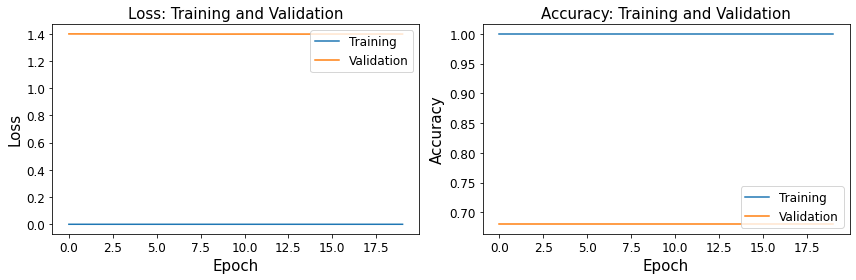

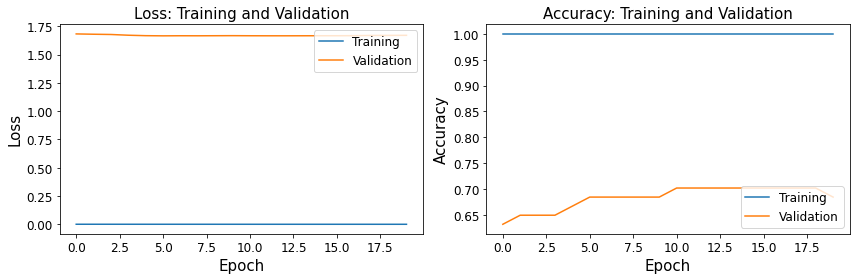

0

In [104]:
# tokenize train, test sentences 
X_trainA2, X_testA2, tokenA = DataTransformations.tokenize(sent_trainA, 
                                                           sent_testA)
X_trainI2, X_testI2, tokenI = DataTransformations.tokenize(sent_trainI, 
                                                           sent_testI)
# pad tokenized train, test sets with 0s as necessary 
X_trainA2, X_testA2 = DataTransformations.pad_tokens(X_trainA2, X_testA2, 100)
X_trainI2, X_testI2 = DataTransformations.pad_tokens(X_trainI2, X_testI2, 100)
# calculate vocab sizes of Amazon, IMDB data sets 
vocabA = DataTransformations.get_vocab_size(tokenA)
vocabI = DataTransformations.get_vocab_size(tokenI)

# define network layers, number of neurons, and initialization, and activations
modelA4 = embed_model(3, 10, 'uniform', vocabA, 50, 100, 'relu', 'sigmoid')
modelI4 = embed_model(3, 10, 'uniform', vocabA, 50, 100, 'relu', 'sigmoid')
# compile model with defined loss function and optimization 
modelA4.compile(optimizer='adam', loss='binary_crossentropy', 
                metrics=['accuracy'])
modelI4.compile(optimizer='adam', loss='binary_crossentropy', 
                metrics=['accuracy'])
# fit models to train data 
historyAmzn = model.fit(X_trainA2, label_trainA, epochs=20, verbose=True, 
                        validation_split=0.1, batch_size=50)
historyImdb = model.fit(X_trainI2, label_trainI, epochs=20, verbose=True,
                        validation_split=0.1, batch_size=50)
# plot model loss and accuracy 
KerasNetwork.plot_metrics(historyAmzn)
KerasNetwork.plot_metrics(historyImdb)

### UNFINISHED DO NOT RUN THIS CELL 

# evaluate model on test data 
#accuracyA = modelA4.evaluate(X_testA2, label_testA, verbose=False)
#accuracyI = modelI4.evaluate(X_testI2, label_testI, verbose=False)
# print model accuracy 
#print("Accuracy of neural network model on AMZN data:", accuracyA[1])
#print("Accuracy of neural network model on IMDB data:", accuracyI[1])

In [103]:
modelA4 = Sequential()
modelA4.add(Embedding(input_dim=vocabA, 
                           output_dim=50, 
                           input_length=100,
                           embeddings_initializer=None)) ## Set embeddings_initializer to some other pre-trained weights for transfer learning
modelA4.add(layers.GlobalMaxPool1D())
modelA4.add(layers.Dense(10, activation='relu'))
modelA4.add(layers.Dense(1, activation='sigmoid'))
modelA4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
modelA4.summary()


modelI4 = Sequential()
modelI4.add(Embedding(input_dim=vocabI, 
                           output_dim=50, 
                           input_length=100,
                           embeddings_initializer=None)) ## Set embeddings_initializer to some other pre-trained weights for transfer learning
modelI4.add(layers.GlobalMaxPool1D())
modelI4.add(layers.Dense(10, activation='relu'))
modelI4.add(layers.Dense(1, activation='sigmoid'))
modelI4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
modelI4.summary()

historyA = modelA4.fit(X_trainA2, label_trainA, epochs=20, verbose=True, validation_split=0.1, batch_size=10)
historyI = modelI4.fit(X_trainI2, label_trainI, epochs=20, verbose=True, validation_split=0.1, batch_size=10)

lossA, accuracyA = modelI4.evaluate(X_testA2, label_testA, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracyA))
lossI, accuracyI = modelI4.evaluate(X_testI2, label_testI, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracyI))



Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_73 (Embedding)    (None, 100, 50)           79900     
                                                                 
 global_max_pooling1d_22 (Gl  (None, 50)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_176 (Dense)           (None, 10)                510       
                                                                 
 dense_177 (Dense)           (None, 1)                 11        
                                                                 
Total params: 80,421
Trainable params: 80,421
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_91"
_________________________________________________________________
 Layer (type)             